In [1]:
#! pip install -U numpy
#! pip install missingno

In [2]:
#pip install pyspark

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import configparser
import datetime as dt
from pyspark.sql.functions import isnan, when, count, col, udf, dayofmonth, dayofweek, month, year, weekofyear, avg, monotonically_increasing_id
from pyspark.sql.types import *
import requests
requests.packages.urllib3.disable_warnings()
from pyspark.sql.functions import year, month, dayofmonth, weekofyear, date_format
from pyspark.sql import SparkSession, SQLContext, GroupedData, HiveContext
from pyspark.sql.functions import *
from pyspark.sql.functions import date_add as d_add
from pyspark.sql.types import DoubleType, StringType, IntegerType, FloatType
from pyspark.sql import functions as F
from pyspark.sql.functions import lit
from pyspark.sql import Row
from pyspark import SparkConf
import datetime, time
import seaborn as sns
import numpy as np
import tools as tools
import matplotlib.pyplot as plt
#import db_properties
%matplotlib inline

### Spark configrations:

In [2]:
sparkConf = SparkConf().setAppName('Flights Analytics Apps')\
        .setMaster('local[5]')\
        .set('spark.executor.memory', '4g')\
        .set('spark.driver.memory', '2g')\
        .set('spark.executor.cores', '2')
spark = SparkSession.builder.config(conf=sparkConf).getOrCreate()

In [3]:
spark

### Filling up dataframe from oracle database tables using spark.read.format ("jdbc")

In [ ]:
# Oracle's details
flights_sql = "select * from flights"
user = "hr"
password = "hr"
server = "DEDICATED"
jdbcUrl = "jdbc:oracle:thin:@//localhost:1521/orclpdb"
jdbcDriver = "oracle.jdbc.OracleDriver"
# Create a data frame by reading data from Oracle via JDBC
flights_df = spark.read.format("jdbc") \
    .option("url", jdbcUrl) \
    .option("query", flights_sql) \
    .option("user", user) \
    .option("password", password) \
    .option("driver", jdbcDriver) \
    .load()

flights_df.toPandas().head(20)

### Exploration the structure and contents of the dataset

In [ ]:
flights_df.toPandas().shape

In [5]:
flights_df.printSchema()

root
 |-- YEAR: decimal(4,0) (nullable = true)
 |-- MONTH: decimal(2,0) (nullable = true)
 |-- DAY: decimal(2,0) (nullable = true)
 |-- DAY_OF_WEEK: decimal(2,0) (nullable = true)
 |-- AIRLINE: string (nullable = true)
 |-- FLIGHT_NUMBER: decimal(6,0) (nullable = true)
 |-- TAIL_NUMBER: string (nullable = true)
 |-- ORIGIN_AIRPORT: string (nullable = true)
 |-- DESTINATION_AIRPORT: string (nullable = true)
 |-- SCHEDULED_DEPARTURE: decimal(4,0) (nullable = true)
 |-- DEPARTURE_TIME: decimal(4,0) (nullable = true)
 |-- DEPARTURE_DELAY: decimal(4,0) (nullable = true)
 |-- TAXI_OUT: decimal(4,0) (nullable = true)
 |-- WHEELS_OFF: decimal(4,0) (nullable = true)
 |-- SCHEDULED_TIME: decimal(4,0) (nullable = true)
 |-- ELAPSED_TIME: decimal(4,0) (nullable = true)
 |-- AIR_TIME: decimal(4,0) (nullable = true)
 |-- DISTANCE: decimal(6,0) (nullable = true)
 |-- WHEELS_ON: decimal(4,0) (nullable = true)
 |-- TAXI_IN: decimal(4,0) (nullable = true)
 |-- SCHEDULED_ARRIVAL: decimal(4,0) (nullable =

## Checking missing values, outliers and inconsistencies in dataset

In [14]:
flights_df.toPandas().describe()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
count,5819079,5819079,5819079,5819079,5819079,5819079,5804358,5819079,5819079,5819079,5732926,5732926,5730032,5730032,5819073,5714008,5714008,5819079,5726566,5726566,5819079,5726566,5714008,5819079,5819079,89884,1063439,1063439,1063439,1063439,1063439
unique,1,12,31,7,14,6952,4897,628,629,1321,1440,1217,184,1440,550,712,675,1363,1440,185,1435,1440,1240,2,2,4,570,154,1067,695,632
top,2015,7,2,4,WN,469,N480HA,ATL,ATL,600,555,-3,12,610,85,80,64,337,2045,5,2100,1645,-8,0,0,B,0,0,0,0,0
freq,5819079,520718,195986,872521,1261855,3975,3768,346836,346904,109943,14829,455407,463189,9313,115062,47441,49791,50069,6569,932909,19470,6490,176899,5803892,5729195,48851,498613,1059955,493417,506486,998723


In [10]:
# Finding nulls values
flights_df.toPandas().isnull().sum()

YEAR                         0
MONTH                        0
DAY                          0
DAY_OF_WEEK                  0
AIRLINE                      0
FLIGHT_NUMBER                0
TAIL_NUMBER              14721
ORIGIN_AIRPORT               0
DESTINATION_AIRPORT          0
SCHEDULED_DEPARTURE          0
DEPARTURE_TIME           86153
DEPARTURE_DELAY          86153
TAXI_OUT                 89047
WHEELS_OFF               89047
SCHEDULED_TIME               6
ELAPSED_TIME            105071
AIR_TIME                105071
DISTANCE                     0
WHEELS_ON                92513
TAXI_IN                  92513
SCHEDULED_ARRIVAL            0
ARRIVAL_TIME             92513
ARRIVAL_DELAY           105071
DIVERTED                     0
CANCELLED                    0
CANCELLATION_REASON    5729195
AIR_SYSTEM_DELAY       4755640
SECURITY_DELAY         4755640
AIRLINE_DELAY          4755640
LATE_AIRCRAFT_DELAY    4755640
WEATHER_DELAY          4755640
dtype: int64

In [6]:
airports_sql = "select * from airports"
# Create a data frame by reading data from Oracle via JDBC
airports_df = spark.read.format("jdbc") \
    .option("url", jdbcUrl) \
    .option("query", airports_sql) \
    .option("user", user) \
    .option("password", password) \
    .option("driver", jdbcDriver) \
    .load()

airports_df.toPandas()

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,DRO,Durango-La Plata County Airport,Durango,CO,USA,37.15152,-107.75377
1,DSM,Des Moines International Airport,Des Moines,IA,USA,41.53493,-93.66068
2,DTW,Detroit Metropolitan Airport,Detroit,MI,USA,42.21206,-83.34884
3,DVL,Devils Lake Regional Airport,Devils Lake,ND,USA,48.11425,-98.90878
4,EAU,Chippewa Valley Regional Airport,Eau Claire,WI,USA,44.86526,-91.48507
...,...,...,...,...,...,...,...
317,DEN,Denver International Airport,Denver,CO,USA,39.85841,-104.66700
318,DFW,Dallas/Fort Worth International Airport,Dallas-Fort Worth,TX,USA,32.89595,-97.03720
319,DHN,Dothan Regional Airport,Dothan,AL,USA,31.32134,-85.44963
320,DIK,Dickinson Theodore Roosevelt Regional Airport,Dickinson,ND,USA,46.79739,-102.80195


In [13]:
airports_df.toPandas().describe()

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
count,322,322,322,322,322,319,319
unique,322,322,308,54,1,319,319
top,RAP,Worcester Regional Airport,Charleston,TX,USA,43.41714,-87.90446
freq,1,1,2,24,322,1,1


In [7]:
airlines_sql = "select * from airlines"
# Create a data frame by reading data from Oracle via JDBC
airlines_df = spark.read.format("jdbc") \
    .option("url", jdbcUrl) \
    .option("query", airlines_sql) \
    .option("user", user) \
    .option("password", password) \
    .option("driver", jdbcDriver) \
    .load()

airlines_df.toPandas()

,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways
5,OO,Skywest Airlines Inc.
6,AS,Alaska Airlines Inc.
7,NK,Spirit Air Lines
8,WN,Southwest Airlines Co.
9,DL,Delta Air Lines Inc.


## Data Transformation

In [165]:
# Converting dataset to pandas dataframe
airlines_pd = airlines_df.toPandas()
airports_pd = airports_df.toPandas()
flights_pd = flights_df.toPandas()

In [166]:
flights_pd.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AA,2307,N505AA,OMA,DFW,600,554,-6,30,624,120,131,91,583,755,10,800,805,5,0,0,None,None,None,None,None,None
1,2015,1,1,4,AA,2363,N560AA,OKC,DFW,600,610,10,42,652,65,85,39,175,731,4,705,735,30,0,0,None,20,0,10,0,0
2,2015,1,1,4,AS,81,N577AS,SEA,ANC,600,557,-3,25,622,234,224,195,1448,837,4,854,841,-13,0,0,None,None,None,None,None,None
3,2015,1,1,4,AS,162,N792AS,FAI,ANC,600,544,-16,26,610,73,80,44,261,654,10,713,704,-9,0,0,None,None,None,None,None,None
4,2015,1,1,4,AS,200,N767AS,SEA,SJC,600,550,-10,21,611,123,124,99,697,750,4,803,754,-9,0,0,None,None,None,None,None,None


In [149]:
flights_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5819079 entries, 0 to 5819078
Data columns (total 40 columns):
 #   Column               Dtype   
---  ------               -----   
 0   YEAR                 object  
 1   MONTH                object  
 2   DAY                  object  
 3   DAY_OF_WEEK          object  
 4   AIRLINE              object  
 5   FLIGHT_NUMBER        object  
 6   TAIL_NUMBER          object  
 7   ORIGIN_AIRPORT       object  
 8   DESTINATION_AIRPORT  object  
 9   SCHEDULED_DEPARTURE  object  
 10  DEPARTURE_TIME       object  
 11  DEPARTURE_DELAY      object  
 12  TAXI_OUT             object  
 13  WHEELS_OFF           object  
 14  SCHEDULED_TIME       object  
 15  ELAPSED_TIME         object  
 16  AIR_TIME             object  
 17  DISTANCE             object  
 18  WHEELS_ON            object  
 19  TAXI_IN              object  
 20  SCHEDULED_ARRIVAL    object  
 21  ARRIVAL_TIME         object  
 22  ARRIVAL_DELAY        object  
 23  DIVERTE

#### I have to change column's data types

In [176]:
# Change columns to float data type
flights_pd[["DEPARTURE_TIME", "DEPARTURE_DELAY","TAXI_OUT","WHEELS_OFF","SCHEDULED_TIME",\
            "ELAPSED_TIME","AIR_TIME","WHEELS_ON","TAXI_IN","ARRIVAL_TIME","ARRIVAL_DELAY",\
            "AIR_SYSTEM_DELAY","SECURITY_DELAY","AIRLINE_DELAY","LATE_AIRCRAFT_DELAY","WEATHER_DELAY","ARRIVAL_DELAY"]] =\
flights_pd[["DEPARTURE_TIME", "DEPARTURE_DELAY","TAXI_OUT","WHEELS_OFF","SCHEDULED_TIME",\
            "ELAPSED_TIME","AIR_TIME","WHEELS_ON","TAXI_IN","ARRIVAL_TIME","ARRIVAL_DELAY",\
            "AIR_SYSTEM_DELAY","SECURITY_DELAY","AIRLINE_DELAY","LATE_AIRCRAFT_DELAY","WEATHER_DELAY","ARRIVAL_DELAY"]].apply(pd.to_numeric)

In [189]:
# Change columns to int64 data type
flights_pd[['YEAR','MONTH','DAY','DAY_OF_WEEK','FLIGHT_NUMBER','SCHEDULED_DEPARTURE','DISTANCE','SCHEDULED_ARRIVAL',\
            'CANCELLED']] = flights_pd[['YEAR','MONTH','DAY','DAY_OF_WEEK','FLIGHT_NUMBER','SCHEDULED_DEPARTURE',\
                                        'DISTANCE','SCHEDULED_ARRIVAL','CANCELLED']].astype('int64')

In [190]:
flights_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5819079 entries, 0 to 5819078
Data columns (total 40 columns):
 #   Column               Dtype   
---  ------               -----   
 0   YEAR                 int64   
 1   MONTH                int64   
 2   DAY                  int64   
 3   DAY_OF_WEEK          int64   
 4   AIRLINE              object  
 5   FLIGHT_NUMBER        int64   
 6   TAIL_NUMBER          object  
 7   ORIGIN_AIRPORT       object  
 8   DESTINATION_AIRPORT  object  
 9   SCHEDULED_DEPARTURE  int64   
 10  DEPARTURE_TIME       float64 
 11  DEPARTURE_DELAY      float64 
 12  TAXI_OUT             float64 
 13  WHEELS_OFF           float64 
 14  SCHEDULED_TIME       float64 
 15  ELAPSED_TIME         float64 
 16  AIR_TIME             float64 
 17  DISTANCE             int64   
 18  WHEELS_ON            float64 
 19  TAXI_IN              float64 
 20  SCHEDULED_ARRIVAL    int64   
 21  ARRIVAL_TIME         float64 
 22  ARRIVAL_DELAY        float64 
 23  DIVERTE

In [178]:
# gathering data to dictionary
airlines_name = airlines_pd.set_index('IATA_CODE')['AIRLINE'].to_dict()

airports_city = airports_pd.set_index('IATA_CODE')['CITY'].to_dict()

airports_name = airports_pd.set_index('IATA_CODE')['AIRPORT'].to_dict()

airports_state = airports_pd.set_index('IATA_CODE')['STATE'].to_dict()

airports_country = airports_pd.set_index('IATA_CODE')['COUNTRY'].to_dict()

In [179]:
flights_pd['FLIGHT_NAME'] = flights_pd['AIRLINE'].map(airlines_name)
flights_pd['FLIGHT_NAME'] = flights_pd['FLIGHT_NAME'].astype('category')

flights_pd['DEST_CITY'] = flights_pd['DESTINATION_AIRPORT'].map(airports_city)
flights_pd['DEST_CITY'] = flights_pd['DEST_CITY'].astype('category')

flights_pd['ORIG_CITY'] = flights_pd['ORIGIN_AIRPORT'].map(airports_city)
flights_pd['ORIG_CITY'] = flights_pd['ORIG_CITY'].astype('category')

flights_pd['DEST_NAME'] = flights_pd['DESTINATION_AIRPORT'].map(airports_name)
flights_pd['DEST_NAME'] = flights_pd['DEST_NAME'].astype('category')

flights_pd['ORIGIN_NAME'] = flights_pd['ORIGIN_AIRPORT'].map(airports_name)
flights_pd['ORIGIN_NAME'] = flights_pd['ORIGIN_NAME'].astype('category')


flights_pd['ORIGIN_STATE'] = flights_pd['ORIGIN_AIRPORT'].map(airports_state)
flights_pd['ORIGIN_STATE'] = flights_pd['ORIGIN_STATE'].astype('category')

flights_pd['DEST_STATE'] = flights_pd['DESTINATION_AIRPORT'].map(airports_state)
flights_pd['DEST_STATE'] = flights_pd['DEST_STATE'].astype('category')

flights_pd['ORIG_COUNTRY'] = flights_pd['ORIGIN_AIRPORT'].map(airports_country)
flights_pd['ORIG_COUNTRY'] = flights_pd['ORIG_COUNTRY'].astype('category')

flights_pd['DEST_COUNTRY'] = flights_pd['DESTINATION_AIRPORT'].map(airports_country)
flights_pd['DEST_COUNTRY'] = flights_pd['DEST_COUNTRY'].astype('category')

In [180]:
flights_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5819079 entries, 0 to 5819078
Data columns (total 40 columns):
 #   Column               Dtype   
---  ------               -----   
 0   YEAR                 object  
 1   MONTH                object  
 2   DAY                  object  
 3   DAY_OF_WEEK          object  
 4   AIRLINE              object  
 5   FLIGHT_NUMBER        object  
 6   TAIL_NUMBER          object  
 7   ORIGIN_AIRPORT       object  
 8   DESTINATION_AIRPORT  object  
 9   SCHEDULED_DEPARTURE  object  
 10  DEPARTURE_TIME       float64 
 11  DEPARTURE_DELAY      float64 
 12  TAXI_OUT             float64 
 13  WHEELS_OFF           float64 
 14  SCHEDULED_TIME       float64 
 15  ELAPSED_TIME         float64 
 16  AIR_TIME             float64 
 17  DISTANCE             object  
 18  WHEELS_ON            float64 
 19  TAXI_IN              float64 
 20  SCHEDULED_ARRIVAL    object  
 21  ARRIVAL_TIME         float64 
 22  ARRIVAL_DELAY        float64 
 23  DIVERTE

Graets! Now our column's data types ready.

## Data Analytics

### Highest 10 cities have arrivals in weekend

<AxesSubplot:title={'center':'Highest 10 flight arrival cities on Weekends'}, xlabel='City', ylabel='Count'>

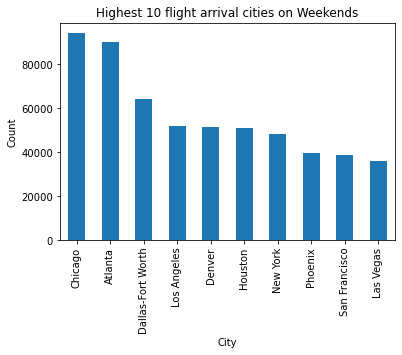

In [106]:
week_end = flights_pd[(flights_pd['DAY_OF_WEEK']==6) | (flights_pd['DAY_OF_WEEK']==7)]
week_end = week_end['DEST_CITY']
week_end.value_counts()[:10].plot.bar(xlabel="City", ylabel="Count",title = 'Highest 10 flight arrival cities on Weekends')

We note here Chicago and Atlanta Airports has a lot flight arrival in weekends , so it's better to go there early if the flight at weekends

### Which 10 highest airports reporting delays?

<AxesSubplot:title={'center':'Highest 10 Airports having more Arrival delay'}, xlabel='Airport Name', ylabel='Count'>

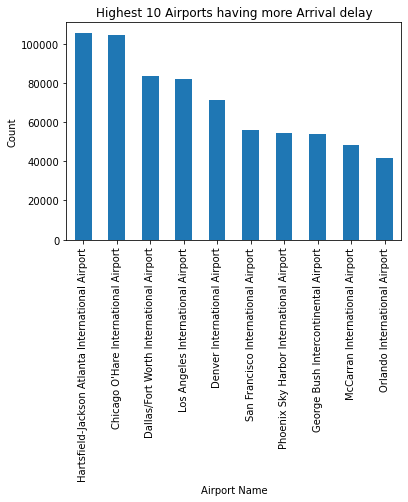

In [105]:
delay_air_ports = flights_pd[flights_pd['ARRIVAL_DELAY'].notnull()]
delay_air_ports = delay_air_ports[delay_air_ports['DEST_NAME'].notnull()]
delay_air_ports = delay_air_ports[['ARRIVAL_DELAY','DEST_NAME']]
delay_air_ports['DELAY'] = np.where(delay_air_ports['ARRIVAL_DELAY'] >= 1, True, False)
delay_air_ports = delay_air_ports[delay_air_ports['DELAY']== True]
delay_air_ports = delay_air_ports['DEST_NAME']
delay_air_ports.value_counts()[:10].plot.bar(xlabel="Airport Name", ylabel="Count",title = 'Highest 10 Airports having more Arrival delay')

### What's the highest 10 Airports having more departure delay?

<AxesSubplot:title={'center':'Highest 10 Airports having more Departure delay'}, xlabel='Airport Name', ylabel='Count'>

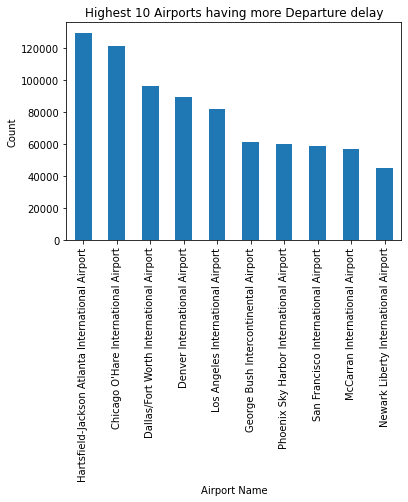

In [107]:
delay_air_ports = flights_pd[flights_pd['DEPARTURE_DELAY'].notnull()]
delay_air_ports = delay_air_ports[delay_air_ports['ORIGIN_NAME'].notnull()]
delay_air_ports = delay_air_ports[['DEPARTURE_DELAY','ORIGIN_NAME']]
delay_air_ports['DELAY'] = np.where(delay_air_ports['DEPARTURE_DELAY'] >= 1, True, False)
delay_air_ports = delay_air_ports[delay_air_ports['DELAY']== True]
delay_air_ports = delay_air_ports['ORIGIN_NAME']
delay_air_ports.value_counts()[:10].plot.bar(xlabel="Airport Name", ylabel="Count",title = 'Highest 10 Airports having more Departure delay')

### Which month has more arrival delay in the year?

<AxesSubplot:title={'center':'Number of Arrival Delays in different months'}, xlabel='Month', ylabel='Count'>

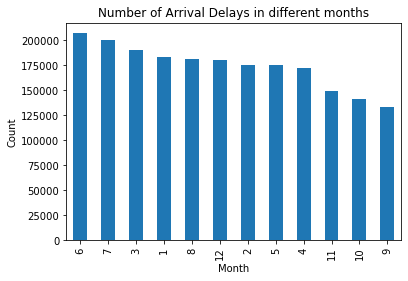

In [108]:
delay_month = flights_pd[flights_pd['ARRIVAL_DELAY'].notnull()]
delay_month = delay_month[['MONTH','ARRIVAL_DELAY']]
delay_month['DELAY'] = np.where(delay_month['ARRIVAL_DELAY'] >= 1, True, False)
delay_month = delay_month[delay_month['DELAY']== True]
delay_month = delay_month['MONTH']
delay_month.value_counts().plot.bar(xlabel="Month", ylabel="Count",title = 'Number of Arrival Delays in different months')

We note that's at half of the year ,the 6th,7th month  there is a lot of Arrival Delayed, but the last part of year is better

### Which airline has the most delays in arrival?

<AxesSubplot:title={'center':'Number of Arrival Delays in different months'}, xlabel='Airline Companies', ylabel='Count'>

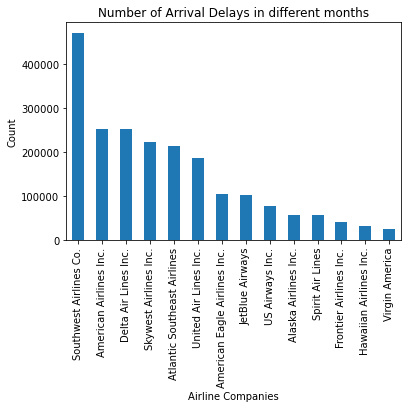

In [110]:
delay_month = flights_pd[flights_pd['ARRIVAL_DELAY'].notnull()]
delay_month = delay_month[['FLIGHT_NAME','ARRIVAL_DELAY']]
delay_month['DELAY'] = np.where(delay_month['ARRIVAL_DELAY'] >= 1, True, False)
delay_month = delay_month[delay_month['DELAY']== True]
delay_month = delay_month['FLIGHT_NAME']
delay_month.value_counts().plot.bar(xlabel="Airline Companies", ylabel="Count",title = 'Number of Arrival Delays in different months')

We note that Virgin America is the most punctual company

### In what day of the month there's more travels?

<AxesSubplot:title={'center':'Flight count on different days of the month'}, xlabel='Day of the month', ylabel='Count'>

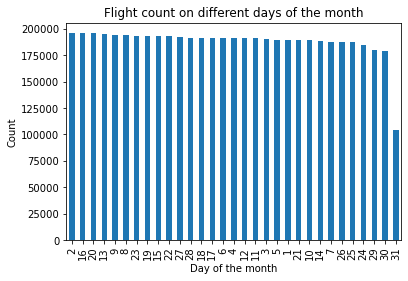

In [207]:
day = flights_pd['DAY']
day.value_counts().plot.bar(xlabel="Day of the month", 
                            ylabel="Count",
                            title = 'Flight count on different days of the month')

No. of flights decreases sequentially at last days of the month approximately by 50%.

<AxesSubplot:title={'center':'Number of Departure Delays in different months'}, xlabel='Month', ylabel='Count'>

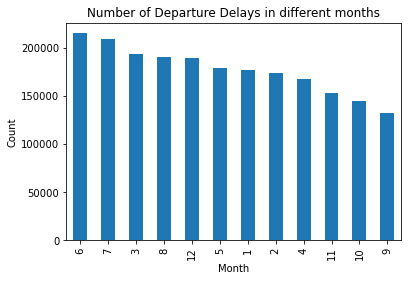

In [118]:
delay_month = flights_pd[flights_pd['DEPARTURE_DELAY'].notnull()]
delay_month = delay_month[['MONTH','DEPARTURE_DELAY']]
delay_month['DELAY'] = np.where(delay_month['DEPARTURE_DELAY'] >= 1, True, False)
delay_month = delay_month[delay_month['DELAY']== True]
delay_month = delay_month['MONTH']
delay_month.value_counts().plot.bar(xlabel="Month", ylabel="Count",title = 'Number of Departure Delays in different months')

Departure delay of flights are happening more in the summer season 6 & 7.

### There's relations between airflying time with arrival delay?

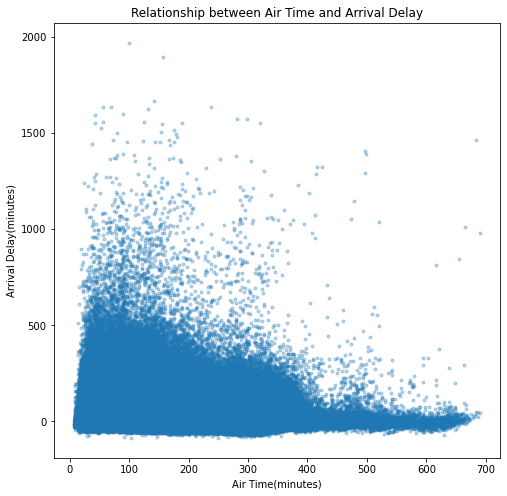

In [120]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 8)
plt.scatter(flights_pd['AIR_TIME'], flights_pd['ARRIVAL_DELAY'],alpha = 0.3, marker = '.')
plt.ylabel('Arrival Delay(minutes)')
plt.xlabel('Air Time(minutes)')
plt.title('Relationship between Air Time and Arrival Delay')
plt.show()

we can say that, Arrival delay decreases when we have more air flying time!

### Witch airports are taking more taxi in and taxi out times?

<ipython-input-192-7225c37c3457>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  taxi_out = taxi_out[flights_pd['TAXI_OUT'].notnull()]


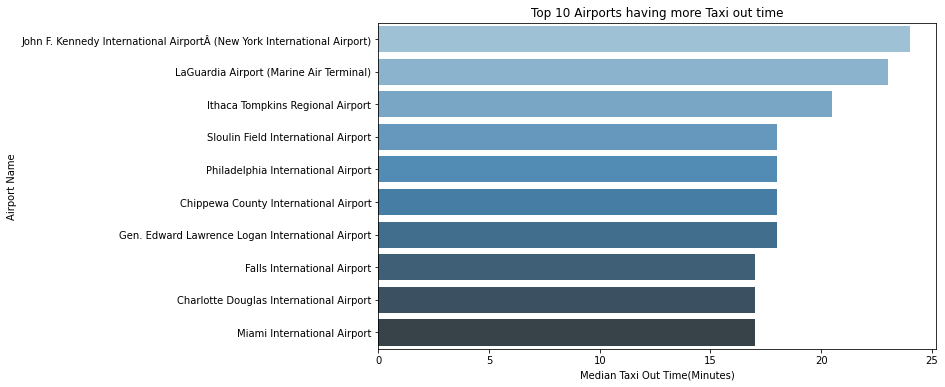

In [192]:
taxi_out = flights_pd[flights_pd['ORIGIN_NAME'].notnull()]
taxi_out = taxi_out[flights_pd['TAXI_OUT'].notnull()]
taxi_out = taxi_out[['ORIGIN_NAME', 'TAXI_OUT']]
taxi_out = taxi_out.groupby(['ORIGIN_NAME'])['TAXI_OUT'].median().reset_index()
taxi_out = taxi_out.sort_values(by='TAXI_OUT', ascending=False, na_position='first').head(10)


plt.figure(figsize=(10,6))
sns.barplot(x='TAXI_OUT', 
            y="ORIGIN_NAME", 
            data=taxi_out, 
            order=taxi_out.sort_values('TAXI_OUT',ascending = False).ORIGIN_NAME,
           palette="Blues_d")
plt.ylabel('Airport Name')
plt.xlabel('Median Taxi Out Time(Minutes)')
plt.title('Top 10 Airports having more Taxi out time')
plt.show()

In New York International Airport, on Average, Flights are taking about 24 minute Taxi Out time

<ipython-input-194-61cf6fdf049f>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  taxi_in = taxi_in[flights_pd['TAXI_IN'].notnull()]


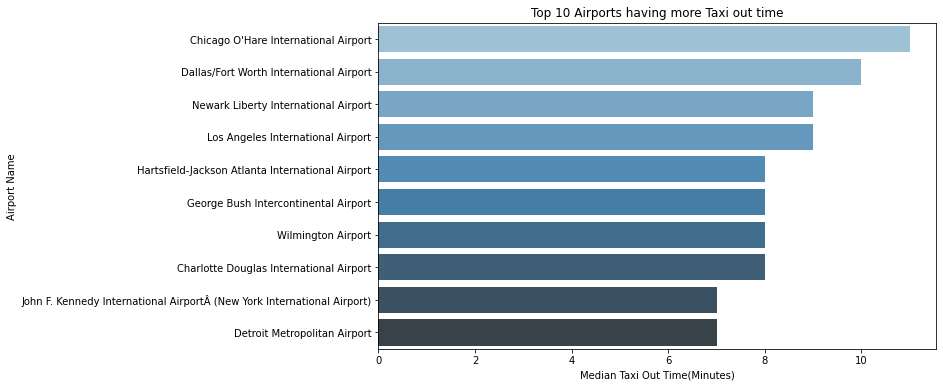

In [194]:
taxi_in = flights_pd[flights_pd['DEST_NAME'].notnull()]
taxi_in = taxi_in[flights_pd['TAXI_IN'].notnull()]
taxi_in = taxi_in[['DEST_NAME', 'TAXI_IN']]
taxi_in = taxi_in.groupby(['DEST_NAME'])['TAXI_IN'].median().reset_index()
taxi_in = taxi_in.sort_values(by='TAXI_IN', ascending=False, na_position='first').head(10)

plt.figure(figsize=(10,6))
sns.barplot(x='TAXI_IN', 
            y="DEST_NAME", 
            data=taxi_in, 
            order=taxi_in.sort_values('TAXI_IN',ascending = False).DEST_NAME,
           palette="Blues_d")
plt.ylabel('Airport Name')
plt.xlabel('Median Taxi Out Time(Minutes)')
plt.title('Top 10 Airports having more Taxi out time')
plt.show()

In Chicago O'Hare International Airport, on Average, Flights are taking about 11 minute Taxi Out time

From the both plts we can say that, Taxi In time Longer than Taxi Out time

### Is it flights get delayed because weather?

In [156]:
total_length = flights_pd.shape[0]
weather_length = flights_pd[flights_pd['WEATHER_DELAY'].notna()]
weather_length = flights_pd[flights_pd['WEATHER_DELAY']>0]
weather_length = weather_length.shape[0]
weather_prop = (weather_length/total_length)*100
print(" {0:.2f}% of delayed due to unexpected Weather".format(weather_prop))

 1.11% of delayed due to unexpected Weather


### Does the flights from same Airline experiencing more delays?

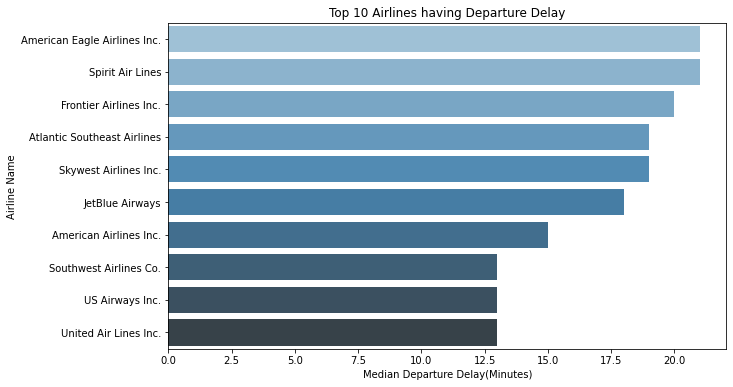

In [196]:
airline_dept = flights_pd[flights_pd['DEPARTURE_DELAY']>0]
airline_dept = airline_dept[['FLIGHT_NAME','DEPARTURE_DELAY']]
airline_dept = airline_dept.groupby(['FLIGHT_NAME'])['DEPARTURE_DELAY'].median().reset_index()
airline_dept = airline_dept.sort_values(by='DEPARTURE_DELAY', ascending=False, na_position='first').head(10)

plt.figure(figsize=(10,6))
sns.barplot(x='DEPARTURE_DELAY', 
            y="FLIGHT_NAME", 
            data=airline_dept, 
            order=airline_dept.sort_values('DEPARTURE_DELAY',ascending = False).FLIGHT_NAME,
           palette="Blues_d")
plt.ylabel('Airline Name')
plt.xlabel('Median Departure Delay(Minutes)')
plt.title('Top 10 Airlines having Departure Delay')
plt.show()

American Eagle Airlines has highest departure delay about 20 minute average

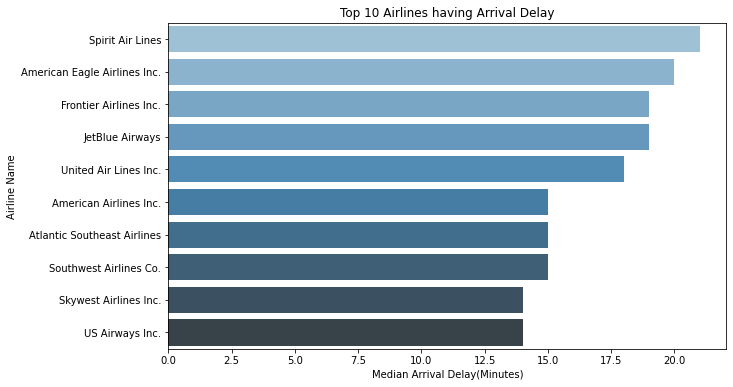

In [197]:
airline_arr = flights_pd[flights_pd['ARRIVAL_DELAY']>0]
airline_arr = airline_arr[['FLIGHT_NAME','ARRIVAL_DELAY']]
airline_arr = airline_arr.groupby(['FLIGHT_NAME'])['ARRIVAL_DELAY'].median().reset_index()
airline_arr = airline_arr.sort_values(by='ARRIVAL_DELAY', ascending=False, na_position='first').head(10)

plt.figure(figsize=(10,6))
sns.barplot(x='ARRIVAL_DELAY', 
            y="FLIGHT_NAME", 
            data=airline_arr, 
            order=airline_arr.sort_values('ARRIVAL_DELAY',ascending = False).FLIGHT_NAME,
           palette="Blues_d")
plt.ylabel('Airline Name')
plt.xlabel('Median Arrival Delay(Minutes)')
plt.title('Top 10 Airlines having Arrival Delay')
plt.show()

Spirit Airlines has highest arrival delay about 20 minute average

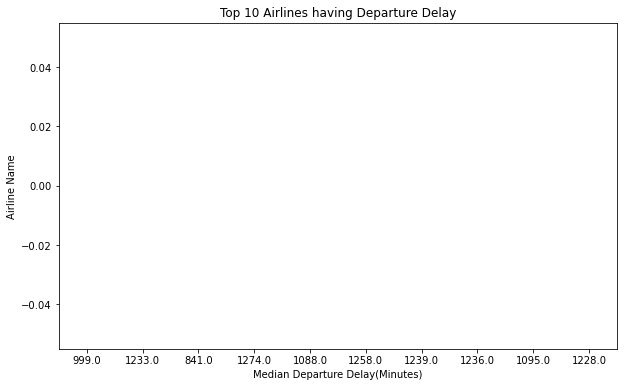

In [199]:
airline_dept = flights_pd[flights_pd['DEPARTURE_DELAY']>0]
airline_dept = airline_dept[['DEPARTURE_DELAY','MONTH']]
airline_dept = airline_dept.groupby(['DEPARTURE_DELAY'])['MONTH'].median().reset_index()
airline_dept = airline_dept.sort_values(by='MONTH', ascending=False, na_position='first').head(10)

plt.figure(figsize=(10,6))
sns.barplot(x='MONTH', 
            y="DEPARTURE_DELAY", 
            data=airline_dept, 
            order=airline_dept.sort_values('MONTH',ascending = False).DEPARTURE_DELAY,
           palette="Blues_d")
plt.ylabel('Airline Name')
plt.xlabel('Median Departure Delay(Minutes)')
plt.title('Top 10 Airlines having Departure Delay')
plt.show()